In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset

import pandas as pd
import spacy

from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import time, math
%matplotlib inline

In [2]:
# !git clone https://github.com/moaaztaha/Image-Captioning

In [35]:
spacy_en = spacy.load('en')
df_path = 'data.csv'
test_df_path = 'test.csv'
images_path = 'Images/'
test_examples_path = 'test_examples/'

In [4]:
class Vocabulary:
    def __init__(self, freq_threshold=2):
        self.freq_threshold = freq_threshold
        self.itos = {0:"<pad>", 1:"<sos>", 2:"<eos>", 3:"<unk>"}
        self.stoi = {"<pad>":0, "<sos>":1, "<eos>":2, "<unk>":3}
        
    def __len__(self):
        return len(self.itos)
    
    @staticmethod
    def tokenize_en(text):
        return [tok.text for tok in spacy_en.tokenizer(text.lower())]
    
    def build_vocabulary(self, sentence_list):
        freqs = {}
        idx = 4
        
        for sentence in sentence_list:
            for word in self.tokenize_en(sentence):
                if word not in freqs:
                    freqs[word] = 1
                else:
                    freqs[word] += 1

                if freqs[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self, text):
        tokenized_text = self.tokenize_en(text)
        
        return [self.stoi[token] if token in self.stoi else self.stoi["<unk>"]
               for token in tokenized_text]
                

In [5]:
class FlickrDataset(Dataset):
    def __init__(self, root_dir, captions_file, vocab, transforms=None, freq_threshold=2, split='train'):
        # split has to be one of {train, val, test}
        assert split in {'train', 'val', 'test'}
        
        self.root_dir = root_dir
        self.df = pd.read_csv(captions_file)
        self.vocab = vocab
        self.transforms = transforms
        
        
        # getting image ids and captions based on split
        self.df = self.df[self.df['split'] == split]
        self.img_idx = self.df['file_name'].values
        self.captions = self.df['caption'].values
        
        
        # printing some info
        print(f"Dataset split: {split}")
        print(f"Unique Image: {self.df.file_name.nunique()}")
        print(f"Size: {self.df.shape[0]}")
    
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, index):
        caption = self.captions[index]
        img_id = self.img_idx[index]
        img = Image.open(self.root_dir+img_id).convert("RGB")
        
        if self.transforms is not None:
            img = self.transforms(img)
        else:
            img = transforms.ToTensor()(img)
        
        # numericalize captions
        word_idx = self.vocab.numericalize(caption)
        caption = [self.vocab.stoi["<sos>"]]
        caption.extend(word_idx)
        caption.append(self.vocab.stoi["<eos>"])
        return img, torch.tensor(caption)

In [6]:
def build_vocab(data_file, freq_threshold=2 ,split='train'):
    df = pd.read_csv(data_file)
    df = df[df['split'] == split]
    captions = df.caption.values
    
    vocab = Vocabulary(freq_threshold)
    vocab.build_vocabulary(captions)
    
    return vocab

In [7]:
vocab = build_vocab(df_path)

In [8]:
def plot_sample(ds, idx):
    img = ds[idx][0]
    img = transforms.ToPILImage()(img).convert("RGB")
    plt.imshow(img)
    caption = ' '.join([ds.vocab.itos[i.item()] for i in ds[idx][1]])
    print(caption)

In [9]:
ds = FlickrDataset(images_path, df_path, vocab=vocab, split='train')

Dataset split: train
Unique Image: 6000
Size: 30000


<sos> black dog chasing brown dog through snow <eos>


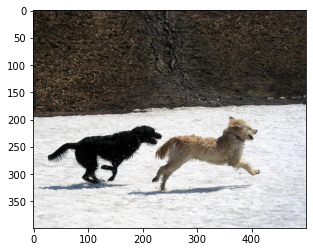

In [10]:
plot_sample(ds, 1)

In [11]:
pad_idx = ds.vocab.stoi['<pad>']

In [12]:
def collate_fn(batch):
    images = [item[0].unsqueeze(0) for item in batch]
    images = torch.cat(images, dim=0)
    
    captions = [item[1] for item in batch]
    captions = pad_sequence(captions, batch_first=False, padding_value=pad_idx)
    
    return images, captions

### Model

In [13]:
class EncoderCNN(nn.Module):
    def __init__(self, hid_dim, dropout, train_cnn=False):
        super().__init__()
        
        self.hid_dim = hid_dim
        self.train_cnn = train_cnn
        
        self.inception = models.inception_v3(pretrained=True, aux_logits=False)
        self.inception.fc = nn.Linear(self.inception.fc.in_features, hid_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, images):
        features = self.dropout(self.relu(self.inception(images)))
        return features

In [14]:
class DecoderRNN(nn.Module):
    def __init__(self, emb_dim, hid_dim, vocab_size, dropout):
        super().__init__()
        
        self.hid_dim = hid_dim
        self.embedding = nn.Embedding(vocab_size, emb_dim)
        self.rnn = nn.LSTM(emb_dim, hid_dim)
        self.linear = nn.Linear(hid_dim, vocab_size)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, features, captions):
        embeddings = self.dropout(self.embedding(captions))
        embeddings = torch.cat((features.unsqueeze(0), embeddings), dim=0)
        rnn_out, _ = self.rnn(embeddings)
        outputs = self.linear(rnn_out)
        return outputs

In [15]:
class Img2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
        assert self.encoder.hid_dim == self.decoder.hid_dim
        
    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs

In [16]:
HID_DIM = 256
EMB_DIM = 256
DROPOUT = .5
VOCAB_LENGTH = len(vocab)
TRAIN_CNN = False
bs = 256
lr = 3e-3

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

encoder = EncoderCNN(HID_DIM, DROPOUT)
decoder = DecoderRNN(EMB_DIM, HID_DIM, VOCAB_LENGTH, DROPOUT)

model = Img2Seq(encoder, decoder, device).to(device)

In [17]:
for name, param in model.encoder.inception.named_parameters():
    if "fc.weight" in name or "fc.bias" in name:
        param.requires_grad = True
    else:
        param.requires_grad = TRAIN_CNN

In [18]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"The model has {count_parameters(model):,} trainable parameters.")

The model has 3,339,373 trainable parameters.


In [19]:
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)
optimizer = optim.Adam(model.parameters(), lr=lr)

In [20]:
# transforms 
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [21]:
import multiprocessing
multiprocessing.cpu_count()

8

In [22]:
train_loader = DataLoader(
    dataset=FlickrDataset(images_path, df_path,transforms=transform, vocab=vocab, split='train'),
    batch_size=bs,
    num_workers=8,
    shuffle=True,
    pin_memory=True,
    collate_fn=collate_fn,
    drop_last=True
)

valid_loader = DataLoader(
    dataset=FlickrDataset(images_path, df_path, transforms=transform, vocab=vocab, split='val'),
    batch_size=bs,
    num_workers=8,
    shuffle=True,
    pin_memory=True,
    collate_fn=collate_fn,
    drop_last=True
)

Dataset split: train
Unique Image: 6000
Size: 30000
Dataset split: val
Unique Image: 1000
Size: 5000


In [23]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for idx, (imgs, captions) in tqdm(enumerate(iterator), total=len(iterator), leave=False, desc="training"):
        
        optimizer.zero_grad()
        
        imgs = imgs.to(model.device)
        captions = captions.to(model.device)
        
        outputs = model(imgs, captions[:-1])
        #output = [trg len, batch size, output dim]
        loss = criterion(
                outputs.reshape(-1, outputs.shape[2]), captions.reshape(-1)
            )
        

        loss.backward()
        
        # clip the grads
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [24]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
        for i, (images, captions) in tqdm(enumerate(iterator), total=len(iterator), leave=False, desc="Evaluating"):
            
            images = images.to(model.device)
            captions = captions.to(model.device)
            
            outputs = model(images, captions[:-1])
            #output = [trg len, batch size, output dim]
            
            loss = criterion(
                outputs.reshape(-1, outputs.shape[2]), captions.reshape(-1)
            )
            
            epoch_loss += loss.item()
    
    return epoch_loss / len(iterator)

In [25]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [26]:
N_EPOCHS = 50
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_loader, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_loader, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'splits.pth')
        
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')  

Epoch: 01 | Time: 3m 28s
	Train Loss: 3.912 | Train PPL:  50.022
	 Val. Loss: 3.208 |  Val. PPL:  24.721


Epoch: 02 | Time: 3m 28s
	Train Loss: 3.120 | Train PPL:  22.638
	 Val. Loss: 2.990 |  Val. PPL:  19.879


Epoch: 03 | Time: 3m 28s
	Train Loss: 2.924 | Train PPL:  18.613
	 Val. Loss: 2.894 |  Val. PPL:  18.068


Epoch: 04 | Time: 3m 29s
	Train Loss: 2.805 | Train PPL:  16.524
	 Val. Loss: 2.830 |  Val. PPL:  16.945


Epoch: 05 | Time: 3m 29s
	Train Loss: 2.703 | Train PPL:  14.929
	 Val. Loss: 2.780 |  Val. PPL:  16.111


Epoch: 06 | Time: 3m 28s
	Train Loss: 2.630 | Train PPL:  13.876
	 Val. Loss: 2.756 |  Val. PPL:  15.740


Epoch: 07 | Time: 3m 28s
	Train Loss: 2.571 | Train PPL:  13.078
	 Val. Loss: 2.737 |  Val. PPL:  15.439


Epoch: 08 | Time: 3m 27s
	Train Loss: 2.518 | Train PPL:  12.408
	 Val. Loss: 2.717 |  Val. PPL:  15.138


Epoch: 09 | Time: 3m 28s
	Train Loss: 2.473 | Train PPL:  11.862
	 Val. Loss: 2.705 |  Val. PPL:  14.956


Epoch: 10 | Time: 3m 29s
	Train Loss: 2.429 | Train PPL:  11.351
	 Val. Loss: 2.693 |  Val. PPL:  14.775


Epoch: 11 | Time: 3m 27s
	Train Loss: 2.395 | Train PPL:  10.968
	 Val. Loss: 2.687 |  Val. PPL:  14.681


Epoch: 12 | Time: 3m 28s
	Train Loss: 2.362 | Train PPL:  10.611
	 Val. Loss: 2.691 |  Val. PPL:  14.748


Epoch: 13 | Time: 3m 29s
	Train Loss: 2.331 | Train PPL:  10.292
	 Val. Loss: 2.680 |  Val. PPL:  14.592


Epoch: 14 | Time: 3m 29s
	Train Loss: 2.304 | Train PPL:  10.018
	 Val. Loss: 2.684 |  Val. PPL:  14.649


Epoch: 15 | Time: 3m 28s
	Train Loss: 2.279 | Train PPL:   9.768
	 Val. Loss: 2.676 |  Val. PPL:  14.521


Epoch: 16 | Time: 3m 27s
	Train Loss: 2.257 | Train PPL:   9.555
	 Val. Loss: 2.680 |  Val. PPL:  14.585


Epoch: 17 | Time: 3m 27s
	Train Loss: 2.235 | Train PPL:   9.342
	 Val. Loss: 2.677 |  Val. PPL:  14.545


Epoch: 18 | Time: 3m 28s
	Train Loss: 2.214 | Train PPL:   9.156
	 Val. Loss: 2.683 |  Val. PPL:  14.628


Epoch: 19 | Time: 3m 28s
	Train Loss: 2.193 | Train PPL:   8.965
	 Val. Loss: 2.683 |  Val. PPL:  14.634


Epoch: 20 | Time: 3m 28s
	Train Loss: 2.177 | Train PPL:   8.823
	 Val. Loss: 2.682 |  Val. PPL:  14.618


Epoch: 21 | Time: 3m 28s
	Train Loss: 2.161 | Train PPL:   8.678
	 Val. Loss: 2.685 |  Val. PPL:  14.663


Epoch: 22 | Time: 3m 28s
	Train Loss: 2.144 | Train PPL:   8.533
	 Val. Loss: 2.691 |  Val. PPL:  14.743


Epoch: 23 | Time: 3m 27s
	Train Loss: 2.129 | Train PPL:   8.404
	 Val. Loss: 2.703 |  Val. PPL:  14.918


Epoch: 24 | Time: 3m 28s
	Train Loss: 2.116 | Train PPL:   8.294
	 Val. Loss: 2.699 |  Val. PPL:  14.858


Epoch: 25 | Time: 3m 28s
	Train Loss: 2.100 | Train PPL:   8.168
	 Val. Loss: 2.703 |  Val. PPL:  14.931


Epoch: 26 | Time: 3m 29s
	Train Loss: 2.086 | Train PPL:   8.054
	 Val. Loss: 2.710 |  Val. PPL:  15.031


Epoch: 27 | Time: 3m 28s
	Train Loss: 2.075 | Train PPL:   7.964
	 Val. Loss: 2.710 |  Val. PPL:  15.024


Epoch: 28 | Time: 3m 28s
	Train Loss: 2.063 | Train PPL:   7.868
	 Val. Loss: 2.715 |  Val. PPL:  15.108


Epoch: 29 | Time: 3m 28s
	Train Loss: 2.054 | Train PPL:   7.796
	 Val. Loss: 2.724 |  Val. PPL:  15.235


Epoch: 30 | Time: 3m 28s
	Train Loss: 2.040 | Train PPL:   7.694
	 Val. Loss: 2.722 |  Val. PPL:  15.206


Epoch: 31 | Time: 3m 26s
	Train Loss: 2.030 | Train PPL:   7.618
	 Val. Loss: 2.732 |  Val. PPL:  15.358


Epoch: 32 | Time: 3m 26s
	Train Loss: 2.022 | Train PPL:   7.555
	 Val. Loss: 2.734 |  Val. PPL:  15.395


KeyboardInterrupt: 

In [38]:
# load best model first
model = Img2Seq(encoder, decoder, device).to(device)
model.load_state_dict(torch.load('splits.pth'))

<All keys matched successfully>

In [42]:
def caption_image(image, model, max_len=50):
    
    model.eval()
    result_caption = []
    
    with torch.no_grad():
        context = model.encoder(image.to(model.device)).unsqueeze(0)
        #hidden = torch.tensor(vocab.stoi["<sos>"]).unsqueeze(0).to(model.device)
        states=None
        
        for t in range(1, max_len):
            output, states = model.decoder.rnn(context, states)
            output = model.decoder.linear(output.squeeze(0))
            top1 = output.argmax(1)
            context = model.decoder.embedding(top1).unsqueeze(0)
            
            result_caption.append(top1.item())
            if vocab.itos[top1.item()] == '<eos>':
                break
    return [vocab.itos[idx] for idx in result_caption]

In [59]:
def print_examples(model, csv_name, root_dir='test_examples'):
    df = pd.read_csv(csv_name)
    imgs = df['image'].tolist()
    captions = df['description'].tolist()
    i = 1
    for img_id, cap in zip(imgs, captions):
        img = Image.open(root_dir+img_id).convert("RGB")
        plt.imshow(img)
        plt.title(f'Example {i} Correct: {cap}')
        plt.axis('off')
        img = transform(img).unsqueeze(0)
        print(f"Output: {' '.join(caption_image(img, model)[1:-1])}")
        plt.show()
        i+=1

Output: <sos> a dog is running through the grass . <eos>


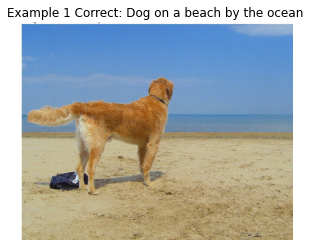

Output: <sos> a little girl in a pink dress is playing with a hula hoop . <eos>


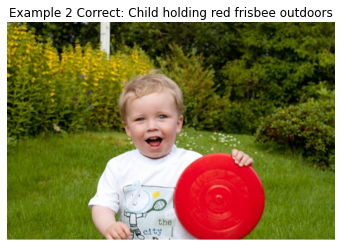

Output: <sos> a man in a red jacket is standing on a rock with a woman in a black jacket . <eos>


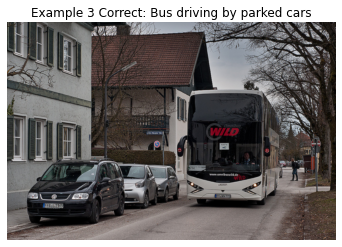

Output: <sos> a man in a blue shirt is standing on a rock overlooking a valley . <eos>


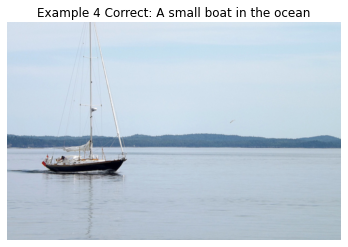

Output: <sos> a man in a red shirt is standing on a rock with a woman in a black jacket . <eos>


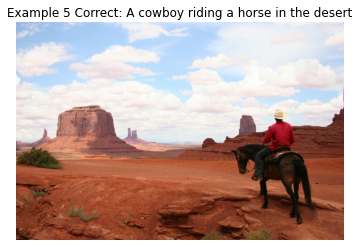

In [44]:
print_examples(model, csv_name=test_df_path, root_dir=test_examples_path)

### BLEU Score 

In [56]:
from torchtext.data.metrics import bleu_score

def calculate_bleu(test_dict, imgs_path, model, max_len=50, n_images=100):
    
    trgs = []
    pred_trgs = []
    
    i = 0
    
    for filename in test_dict:
        if i == n_images:break
        
        # getting the test image
        img = Image.open(imgs_path+'/'+filename).convert("RGB")
        img = transform(img).unsqueeze(0) # making it into a batch
        
        # making prediction
        pred = caption_image(img, model)
        
        if i % (n_images//10) == 0 and i!=0:
            print("prediction:", ' '.join(x for x in pred[1:-1]))
            print("actaul 1:", ' '.join(x for x in test_dict[filename][0]))
            
        
        pred_trgs.append(pred[:-1])
        trgs.append(test_dict[filename])
        
        i+=1
        
    return bleu_score(pred_trgs, trgs)

In [57]:
# getting test data
df = pd.read_csv(df_path)
test_df = df[df['split'] == 'test']

img_ids = test_df.file_name.unique()

test_dict = {}
for img_id in img_ids:
    list_tokens = []
    for sent in test_df[test_df['file_name'] == img_id]['caption'].values:
        list_tokens.append(Vocabulary.tokenize_en(sent))
    
    test_dict[img_id] = list_tokens

In [58]:
calculate_bleu(test_dict, images_path, model, n_images=1000)

prediction: a black dog is running through the grass .
actaul 1: a group of dogs runs beside a pond through a field .
prediction: a man in a red shirt and a black jacket is standing next to a woman in a white shirt .
actaul 1: a girl wets her head in a white bucket .
prediction: a man in a red shirt and a woman in a white shirt and sunglasses .
actaul 1: a group of men wearing yellow shawls walk in a line .
prediction: a man in a red shirt is standing on a rock with a man in a black shirt .
actaul 1: a boy and a girl playing on the beach .
prediction: a man in a red shirt is standing in front of a large crowd of people .
actaul 1: children participate in a sport on a green field while in uniforms .
prediction: a black and white dog is running through the grass .
actaul 1: a boy wearing a teal shirt is riding a skateboard on a sidewalk .
prediction: a man in a blue shirt is surfing on a wave .
actaul 1: a boy jumping over another boy on a trampoline .
prediction: a young boy is playing 

0.08615056425333023